## Training a Periodicity is Hard for a simple neural network, it's just an experiment to train a model on sine wave.

In [128]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split, TensorDataset, DataLoader

In [129]:
seed = 123
dtype = torch.float32
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
torch.set_default_device(device)
torch.manual_seed(seed)
generator = torch.Generator(device=device).manual_seed(seed)

In [130]:
def generate_sine_data():
    X = torch.arange(-10, 10, 0.01, dtype=torch.float32, device=device).unsqueeze(1)
    y = torch.sin(X)

    X_mean = X.mean()
    X_std = X.std()
    X = (X - X_mean) / X_std

    y_mean = y.mean()
    y_std = y.std()
    y = (y - y_mean) / y_std

    return X, y, X_mean, y_mean, X_std, y_std

X_dataset, y_dataset, X_mean, y_mean, X_std, y_std = generate_sine_data()

dataset = TensorDataset(X_dataset, y_dataset)
total_size = len(dataset)

train_size = int(total_size * 0.6)
val_size = int(total_size * 0.2)
test_size = int(total_size * 0.2)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, generator=generator)  

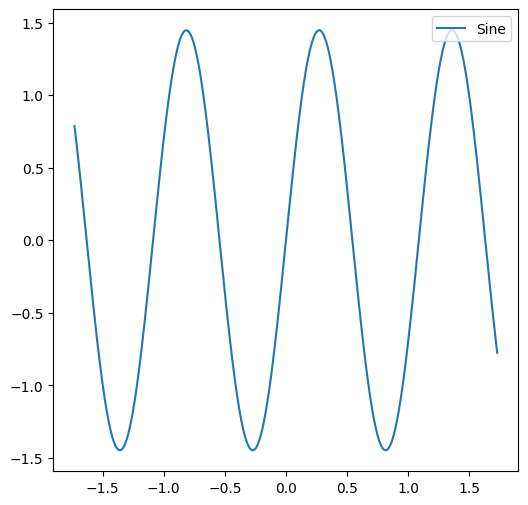

In [131]:
def plot_sine_data(X, y):
    plt.figure(figsize=(6,6))
    plt.plot(X.cpu(), y.cpu(), label = 'Sine')
    plt.legend(loc = 1)
    plt.show()

plot_sine_data(X_dataset, y_dataset)

In [132]:
class SineModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SineModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )

    def forward(self, input):
        return self.layers(input)

In [133]:
epoch = 50
print_per_epoch = 10

def eval(model, loss_fn, val_loader):
    running_loss = 0
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(val_loader):
            inputs, labels = data

            y_pred = model(inputs)

            loss = loss_fn(y_pred, labels)
            running_loss += loss.item()
    return running_loss / len(val_loader)

def train(model, loss_fn, optimizer, train_loader, val_loader):
    model.train()

    for i in range(epoch):
        running_loss = 0
        for _, batch in enumerate(train_dataset):
            X, y = batch
            
            optimizer.zero_grad()

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            running_loss += loss.item()

            loss.backward()

            optimizer.step()
        train_loss_avg = running_loss / len(train_loader)
        val_loss_avg = eval(model, loss_fn, val_loader)

        if (i+1)%print_per_epoch == 0:
            print('LOSS train {:.8f} valid {:.8f}'.format(train_loss_avg, val_loss_avg))

def test(model, loss_fn, test_loader):
    model.eval()
    test_loss = 0
    x_true = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)

            loss = loss_fn(outputs, y)

            test_loss += loss.item()
            x_true.append(X)
            y_pred.append(outputs)
            y_true.append(y)

    x_true = torch.cat(x_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)

    avg_loss = test_loss / len(test_loader)

    print(f"Test Loss: {avg_loss:.8f}")
    return x_true, y_true, y_pred

In [134]:
input_size = 1
output_size = 1
learning_rate = 1e-3

model = SineModel(input_size, output_size)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, loss_fn, optimizer, train_loader, val_loader)
x_true, y_true, y_pred, = test(model, loss_fn, test_loader)

LOSS train 0.78208225 valid 0.01432397
LOSS train 0.46501685 valid 0.00388507
LOSS train 0.42897916 valid 0.00401805
LOSS train 0.34772251 valid 0.00200358
LOSS train 0.29311072 valid 0.00261309
Test Loss: 0.00284728
